# Demand and Travel Decision

In this tutorial we introduce the `demand` and `travel_decision` module of `mnms`. The management of the demand is made through the `DemandManager` classes. We cover two of them:

* `BaseDemandManager`
* `CSVDemandManager`
 
And the choice of the `User` path is made with the `travel_decision` module. We introduce two classes for that:

* `SimpleDecisionModel`
* `LogitDecisionModel`

## Generate a simple graph

We use a simple grid `flow_graph` generated with the function `create_grid_graph`, then we add one mobility service that cover all the `flow_graph`.

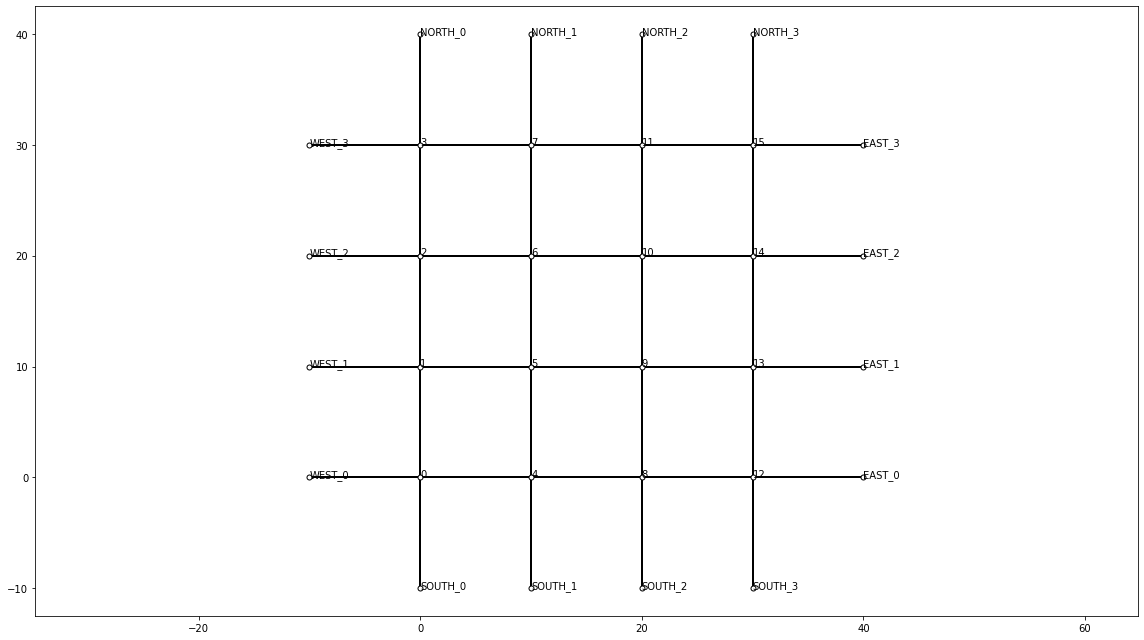

In [2]:
import matplotlib.pyplot as plt

from mnms.generation.mlgraph import generate_manhattan_passenger_car
from mnms.tools.render import draw_roads

mlgraph = generate_manhattan_passenger_car(4, 10)

fig, ax = plt.subplots(figsize=(16, 9))
draw_roads(ax, mlgraph.roads, linkwidth=2, nodesize=5)

## Demand

### Random demand

In the following we create a random demand, the function `create_random_demand` return a `BaseDemandManager`.

In [3]:
from mnms.generation.demand import generate_random_demand

demand = generate_random_demand(mlgraph,
                                10,
                                tstart="10:00:00", 
                                tend="12:00:00", 
                                cost_path='length', 
                                min_cost=0.4)
demand.show_users()

User('0', ORIGIN_WEST_1->DESTINATION_SOUTH_1, 10:01:57.64)
User('1', ORIGIN_EAST_3->DESTINATION_WEST_3, 10:22:09.34)
User('2', ORIGIN_6->DESTINATION_NORTH_2, 10:26:04.83)
User('3', ORIGIN_EAST_2->DESTINATION_3, 10:41:01.93)
User('4', ORIGIN_NORTH_1->DESTINATION_WEST_2, 10:49:22.69)
User('5', ORIGIN_EAST_3->DESTINATION_WEST_1, 11:03:51.69)
User('6', ORIGIN_WEST_3->DESTINATION_EAST_0, 11:09:50.65)
User('7', ORIGIN_NORTH_1->DESTINATION_9, 11:25:52.41)
User('8', ORIGIN_0->DESTINATION_EAST_1, 11:35:52.21)
User('9', ORIGIN_4->DESTINATION_5, 11:38:23.5)
User('10', ORIGIN_4->DESTINATION_1, 11:56:16.16)


### CSV Predefined demand

We can use a predefined demand, the `CSVDemandManager` can read a sorted demand by time from a CSV file.

There is an example of demand in CSV format:

In [4]:
import pandas as pd

pd.read_csv('data/simple_demand.csv', sep=';')

,ID,TIME,ORIGIN,DESTINATION
0,0,07:00:00,ORIGIN_SOUTH_0,DESTINATION_12
1,1,07:10:00,ORIGIN_NORTH_2,DESTINATION_SOUTH_0
2,2,07:20:00,ORIGIN_11,DESTINATION_WEST_0
3,4,07:30:00,ORIGIN_WEST_3,DESTINATION_NORTH_3


And how to load it in `mnms`:

In [5]:
from mnms.demand import CSVDemandManager
from mnms.time import Time

demand = CSVDemandManager('data/simple_demand.csv')

users = demand.get_next_departures(Time("07:00:00"), Time("07:30:00"))
users

[User('0', ORIGIN_SOUTH_0->DESTINATION_12, 07:00:00.00),
 User('1', ORIGIN_NORTH_2->DESTINATION_SOUTH_0, 07:10:00.00),
 User('2', ORIGIN_11->DESTINATION_WEST_0, 07:20:00.00)]

## Travel Decision

The `travel_decision` module is used to choose the path of a a `User`, from a pair origin/destination it computes a path that will be later use in a `FlowMotor`.

In [6]:
from mnms.generation.layers import generate_matching_origin_destination_layer

odlayer = generate_matching_origin_destination_layer(mlgraph.roads)

### SimpleDecisionModel

The `SimpleDecisionModel` only compute the best shortest path for the `User` and set its `path` attribute

In [7]:
from mnms.travel_decision import DummyDecisionModel

travel_decision = DummyDecisionModel(mlgraph, cost="length")

first_user = users[0]
print(f"{first_user}, path: {first_user.path}")

User('0', ORIGIN_SOUTH_0->DESTINATION_12, 07:00:00.00), path: None


In [8]:
travel_decision([first_user])

print(f"{first_user}, path: {first_user.path.nodes}")

User('0', ORIGIN_SOUTH_0->DESTINATION_12, 07:00:00.00), path: ['ORIGIN_SOUTH_0', 'CAR_SOUTH_0', 'CAR_0', 'CAR_4', 'CAR_8', 'CAR_12', 'DESTINATION_12']


### LogitDecisionModel

The `LogitDecisionModel` compute `n` best shortest path and set a probability of choosing a path following this model:

\begin{equation}
p_j=\frac{e^{-\theta c_j}}{\sum_{i=1}^ne^{-\theta c_i}}
\end{equation}

Where:

* c is the cost of the path
* $\theta$ is the logit parameter
* n is the number of path

In [9]:
from mnms.travel_decision import LogitDecisionModel

travel_decision = LogitDecisionModel(mlgraph,
                                     cost="length",
                                     theta=0.01,
                                     n_shortest_path=2)

second_user = users[1]
print(f"{second_user}, path: {second_user.path}")

User('1', ORIGIN_NORTH_2->DESTINATION_SOUTH_0, 07:10:00.00), path: None


In [10]:
travel_decision([second_user])

print(f"{second_user}, path:\n {second_user.path}")

User('1', ORIGIN_NORTH_2->DESTINATION_SOUTH_0, 07:10:00.00), path:
 Path(path_cost=70.0, nodes=['ORIGIN_NORTH_2', 'CAR_NORTH_2', 'CAR_11', 'CAR_10', 'CAR_6', 'CAR_5', 'CAR_4', 'CAR_0', 'CAR_SOUTH_0', 'DESTINATION_SOUTH_0'], layers=[('CAR', slice(1, 9, 1))], services=['PersonalCar'])


### Rendering path

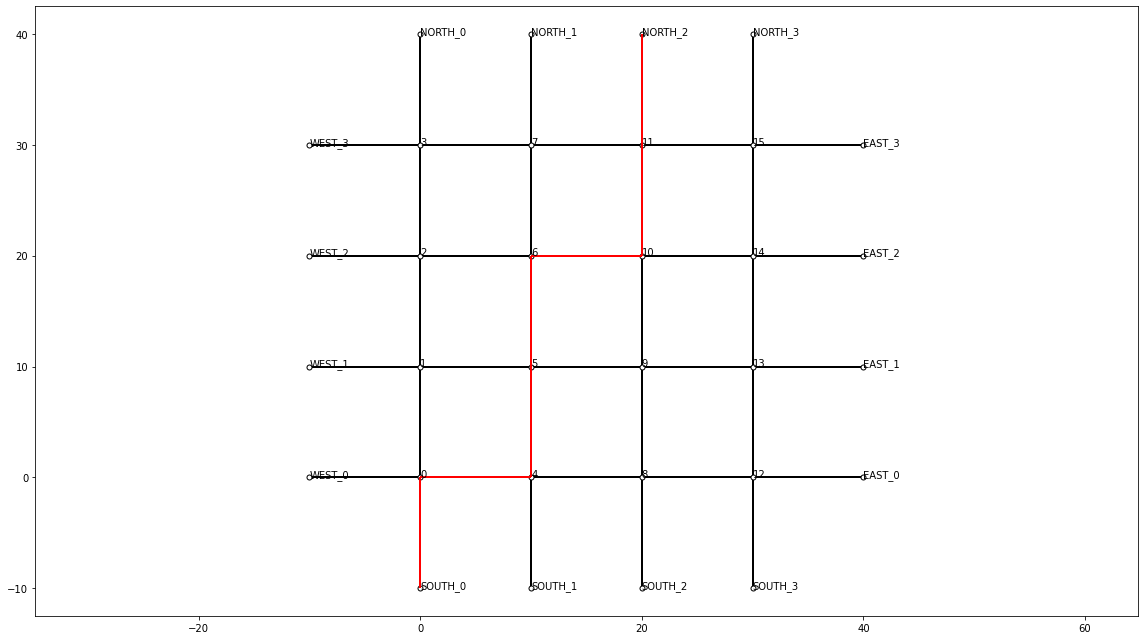

In [11]:
from mnms.tools.render import draw_path

fig, ax = plt.subplots(figsize=(16, 9))
draw_roads(ax, mlgraph.roads, linkwidth=2, nodesize=5)
draw_path(ax, mlgraph, second_user.path)